<a href="https://colab.research.google.com/github/mk1encer/HandsOnML/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X,y=mnist['data'],mnist['target']
print(type(X))

<class 'numpy.ndarray'>


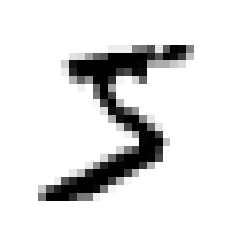

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
y=y.astype(np.uint8)

In [9]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9,random_state=100)


X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# 훈련세트를 섞어서 모든 교차검증폴드를 비슷하게 만들어 주는 것이 좋다. 어떤 학습 알고리즘은 샘플 훈서에 민감해서 비슷한 샘플이 연이어 나타나면 성능이 나빠짐.

## *이진 분류기 훈련*

In [10]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

확률적 경사하강법(SGD)로 훈련.
 SGD는 한번에 하나씩 훈련샘플을 독립적으로 처리해서 매우 큰 데이터셋을 효율적으로 처리함(온라인 학습에 적합)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
#SGDClassifier는 무작위성을 훈련시 사용하므로 재현하려면 매개변수지정 필요.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

정확도가 95%이상. 다음은 모든 이미지를 5아님으로 분류하는 더미 분류기를 만들어보겠다.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X,y=None):
    return self
  
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [15]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

숫자가 0-9 10개이므로 모두5아님으로 분류해도 정확도가 90%가까이 나오는것을 알 수 있음.
**그러므로 정확도는 분류기의 성능측정지표로 적합하지 않다.**

오차행렬을 사용하는 편이 낫다.

오차행렬을 만들기 위해서는 예측값을 만들어야 하는데 테스트세트로 하면 안되고 cross_val_predict()함수를 이용하면 된다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict()함수는 cross_val_score()함수와 동일하게 k-겹 교차검증을 수행하지만 평가점수 반환이 아닌 각 테스트폴드에서 얻은 예측을 반환하므로 모든 훈련세트 샘플에 대해 꺠끗한 예측을 얻을 수 있다.

confusion_matrix()함수를 사용하면 오차행렬을 만들 수 있음.

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬에서 행(가로)은 실제 클래스, 열은 예측한 클래스

**즉, True Negative, False Positive, False Negative, True Positive 순이다.**

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

완벽한 분류기라면 False Positive, False Negative값이 0이 된다.

정밀도: True로 분류한 결과중 몇개가 맞게 분류되었는지
  TP/TP+FP
  **precision_score()로 구할 수 있음**

재현율: 전체 True 데이터중 몇개가 True로 분류되었는지
  TP/TP+FN
  **recall_score()로 구할 수 있음**

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.8370879772350012
0.6511713705958311


정밀도와 재현율의 조화평균이 F1-score이다. 
**이 또한 f1_score()함수로 구할 수 있음**

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷하면 f1점수가 높은데 상황에 따라 정밀도, 재현율중 중요한 것이 다르므로 고려해야함. 
# 정밀도/재현율 trade-off

SGD분류기는 결정함수가 threshold보다 크면 양성, 작으면 음성으로 분류한다. 사이킷런에서 predict()대신 decision_function()메소드를 호출하면 임계값을 정할 수 있다.

In [21]:
y_scores=sgd_clf.decision_function([some_digit])
print(y_scores)
threshold=0
y_some_digit_pred=(y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [22]:
threshold=8000
y_some_digit_pred=(y_scores > threshold)
print(y_some_digit_pred)

[False]


threshold가 높아지면 재현율이 줄어든다.
적절한 threshold를 구하기 위해 cross_val_predict()함수를 사용해 모든 샘플의 점수를 구해야한다.**(예측결과가 아니라 결정점수를 반환받아야함)**

In [23]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)


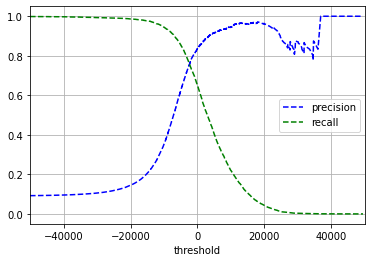

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
  plt.plot(thresholds, recalls[:-1],'g--',label='Recall')
  plt.xlabel('threshold')
  plt.legend(['precision','recall'])
  plt.xlim(-50000,50000)
  plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

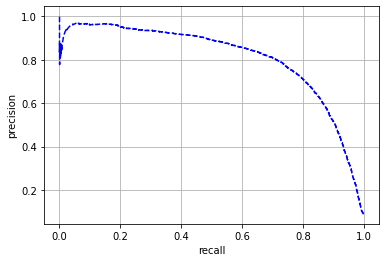

In [26]:
def plot_precision_recall(precisions, recalls):
  plt.plot(recalls[:-1], precisions[:-1],'b--',label='Precision')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.grid(True)

plot_precision_recall(precisions, recalls)
plt.show()

np.argmax()는 최댓값의 첫 번째 인덱스를 반환한다.

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print(threshold_90_precision)

3370.0194991439557


훈련세트에 대한 예측을 만들려면 predict메소드 대신 다음 코드를 실행하면 된다.

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9000345901072293
0.4799852425751706


# ROC 곡선
거짓양성비율에 대한 진짜양성비율의 곡선

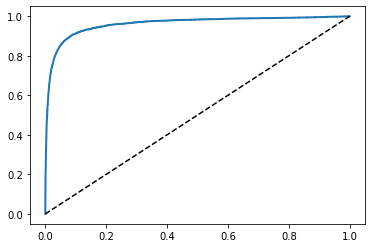

In [29]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)
plt.show()

곡선 아래의 면적(AUC)를 측정하여 분류기를 비교할 수 있다.

-일반적으로 양성인 클래스가 드물거나 거짓음성보다 거짓양성이 더 중요할 때는 PR곡선을 사용하고 그렇지 않으면 ROC곡선을 사용한다.

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 비교.

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=4,method="predict_proba")

In [32]:
y_scores_forest=y_probas_forest[:,1] #score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

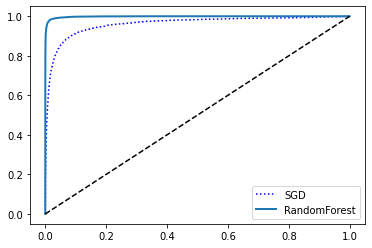

In [33]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984268710591231

# 다중 분류
두개 이상의 클래스를 구별하는 분류기
이진분류기를 여러개 써서 구현하는 것도 가능하다(OvR: One versus Rest)
다중분류작업에 이진분류알고리즘을 선택하면 사이킷런이 알아서 OvR 또는 OvO를 실행한다.

In [35]:
from sklearn.svm import SVC
scm_clf=SVC()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [36]:
some_digit_scores=sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


In [37]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[3])

3
[0 1 2 3 4 5 6 7 8 9]
3


사이킷런에서 OvO 또는 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.

In [38]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SGDClassifier(random_state=42))
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
len(ovr_clf.estimators_)

10

SVM대신 SGDClassifier를 훈련시킬수도 있음. 이경우 Ovr,OvO 필요x

In [ ]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function([some_digit]))

In [ ]:
cross_val_score(sgd_clf, X_train, y_train,cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled, y_train, cv=3, scoring="accuracy")

오차행렬을 통해 만들어진 에러 종류 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_5)
print(conf_mx)

**matplotlib의 matshow함수를 사용해 이미지로 표현하면 한눈에 보기 좋다.**

In [ ]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()